## Sentiment Analyzer
### Author : George M Cherian

In [1]:
#importing the necessary modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
#Loading the dataset(excel sheet) into the dataframe
df = pd.read_excel('reviews.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6934 entries, 0 to 6933
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order Id       6934 non-null   object 
 1   Order Status   6912 non-null   object 
 2   Item Name      6912 non-null   object 
 3   Item Quantity  6912 non-null   float64
 4   Rating         1566 non-null   object 
 5   Feedback       232 non-null    object 
dtypes: float64(1), object(5)
memory usage: 325.2+ KB


In [5]:
# Data Cleaning - Eliminating duplicate rows
df = df.drop_duplicates()

In [6]:
# Data Cleaning - Dropping all cancelled orders
df = df[df['Order Status']!='CANCELLED']

In [7]:
# Feature Engineering - Splitting Rating Column into Rating and Summary
# Data Cleaning - Dropping duplicated order id's
df = df[df['Feedback'].notna()].drop_duplicates('Order Id')
df['Feedback'] = df['Feedback'].str.lower()
df = df.reset_index()
rating = []
summary = []

for val in df['Rating']:
    rating.append(int(val[0]))
    summary.append(val[2:])
    
df = df.drop(['Rating'],axis=1)
df['Rating'] = rating
df['Summary'] = summary


In [8]:
pd.set_option("display.max_colwidth",100)
df.style.set_properties(**{'text-align':'left'}).set_table_styles([dict(selector='th', props=[('text-align','center')])])

,index,Order Id,Order Status,Item Name,Item Quantity,Feedback,Rating,Summary
0,18,10701530888,DELIVERED,Homely Dal Tadka Thali with Sweet,1.000000,i don't think it's delivery guy fault but packet was broken due to some leakage it is like some leftover food,1,VERY BAD
1,33,106989449753,DELIVERED,Homely Chicken Masala Thali with Sweet,1.000000,i liked the quantity of the food and the taste.,5,LOVED IT
2,49,106762961007,DELIVERED,Homely Bhindi Masala Thali with Sweet,1.000000,"bhindi was very raw, butter milk had a foul smell",2,BAD
3,75,106499865637,DELIVERED,Egg Masala,1.000000,"one of the 3rd class restaurant. i ordered egg masala, they sent egg curry, i ordered green salad, they sent 3 slices of onions and 3 slices of tomatoes and charged me 49 rupees.",1,VERY BAD
4,107,106330086944,DELIVERED,"Chicken Masala Rice Bowl, Butter Milk",1.000000,chicken bowl had only two pieces of chicken,2,BAD
5,389,105863931119,DELIVERED,"Voosh Paneer Premium Thali with Sweet, Butter Milk",1.000000,the phulka was semi-coocked.,3,AVERAGE
6,398,105794771832,DELIVERED,Aloo Gobhi,1.000000,looks like a fake copy of voosh,1,VERY BAD
7,502,107511379634,DELIVERED,Homely Dal Tadka Thali with Sweet,1.000000,the bhindi sabji had too much onion and tomatoes also the rice was very stiff,3,AVERAGE
8,773,107716313565,DELIVERED,Set of Chapatis (4 - Chapatis),3.000000,quintyty is not good,1,VERY BAD
9,797,107680227164,DELIVERED,Homely Aloo Gobhi Thali with Sweet,1.000000,no gobi in alo gobi and it was too much spicy. i mean i love spicy food but this was some mistake. couldn't eat.,2,BAD


Text(0.5, 1.0, 'No:of reviews corresponding to each rating')

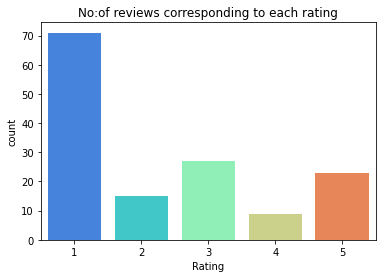

In [9]:
pl = sns.countplot(data=df.sort_values(by='Rating'),x='Rating',palette='rainbow')
pl.set_title('No:of reviews corresponding to each rating')

In [10]:
#Importing the required modules for NLP and text_cleaning
import nltk
from nltk.corpus import stopwords
!pip install wordcloud --upgrade --quiet
from wordcloud import WordCloud

In [11]:
#nltk.download('punkt')

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
review_text = ''.join(feedback for feedback in df.Feedback)

In [14]:
wordcloud = WordCloud(stopwords=stop_words).generate(review_text)

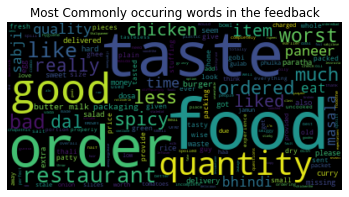

In [15]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Commonly occuring words in the feedback')
plt.savefig('wordcloud.png')
plt.show()

In [16]:
# Calculating Sentiment : Good(1) if rating is greater than 0
# Bad(0) if rating is lesser than or equal to 3
df['Sentiment'] = df['Rating'].apply(lambda x : 1 if x > 3 else 0)

In [17]:
pd.set_option("display.max_colwidth",100)
df.style.set_properties(**{'text-align':'left'}).set_table_styles([dict(selector='th', props=[('text-align','center')])])

,index,Order Id,Order Status,Item Name,Item Quantity,Feedback,Rating,Summary,Sentiment
0,18,10701530888,DELIVERED,Homely Dal Tadka Thali with Sweet,1.000000,i don't think it's delivery guy fault but packet was broken due to some leakage it is like some leftover food,1,VERY BAD,0
1,33,106989449753,DELIVERED,Homely Chicken Masala Thali with Sweet,1.000000,i liked the quantity of the food and the taste.,5,LOVED IT,1
2,49,106762961007,DELIVERED,Homely Bhindi Masala Thali with Sweet,1.000000,"bhindi was very raw, butter milk had a foul smell",2,BAD,0
3,75,106499865637,DELIVERED,Egg Masala,1.000000,"one of the 3rd class restaurant. i ordered egg masala, they sent egg curry, i ordered green salad, they sent 3 slices of onions and 3 slices of tomatoes and charged me 49 rupees.",1,VERY BAD,0
4,107,106330086944,DELIVERED,"Chicken Masala Rice Bowl, Butter Milk",1.000000,chicken bowl had only two pieces of chicken,2,BAD,0
5,389,105863931119,DELIVERED,"Voosh Paneer Premium Thali with Sweet, Butter Milk",1.000000,the phulka was semi-coocked.,3,AVERAGE,0
6,398,105794771832,DELIVERED,Aloo Gobhi,1.000000,looks like a fake copy of voosh,1,VERY BAD,0
7,502,107511379634,DELIVERED,Homely Dal Tadka Thali with Sweet,1.000000,the bhindi sabji had too much onion and tomatoes also the rice was very stiff,3,AVERAGE,0
8,773,107716313565,DELIVERED,Set of Chapatis (4 - Chapatis),3.000000,quintyty is not good,1,VERY BAD,0
9,797,107680227164,DELIVERED,Homely Aloo Gobhi Thali with Sweet,1.000000,no gobi in alo gobi and it was too much spicy. i mean i love spicy food but this was some mistake. couldn't eat.,2,BAD,0


In [18]:
good_reviews = df[df['Sentiment']==1].reset_index()
bad_reviews = df[df['Sentiment']==0].reset_index()

In [19]:
#good_reviews (Uncomment to see good reviews)

In [20]:
#bad_reviews (uncomment to see bad reviews)

In [21]:
good = " ".join(feedback for feedback in good_reviews['Feedback'])

In [22]:
# Dropping these words from the review because they're common to both good and bad reveiws
stop_words.update(['order','food','taste','good','quantity'])

In [23]:
# Generating a corpus containing words in positive reviews
positive_wordcloud = WordCloud(stopwords=stop_words).generate(good)
positive_corpus = nltk.sent_tokenize(good)
positive_corpus = ''.join(positive_corpus)

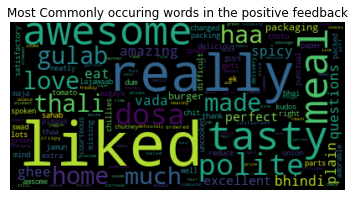

In [24]:
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Commonly occuring words in the positive feedback')
plt.savefig('poswordcloud.png')
plt.show()

In [25]:
bad = " ".join(feedback for feedback in bad_reviews['Feedback'])

In [26]:
# Generating a corpus containing words in negative reviews
negative_wordcloud = WordCloud(stopwords=stop_words).generate(bad)
negative_corpus = nltk.sent_tokenize(bad)
negative_corpus = ''.join(negative_corpus)

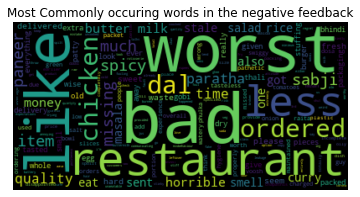

In [27]:
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Commonly occuring words in the negative feedback')
plt.savefig('negwordcloud.png')
plt.show()

In [28]:
# Cleaning the feedback by removing punctuation,other characters and stopwords
clean_Feedback = []
for feedback in df['Feedback']:
    f = []
    for char in feedback:
        if char.isalnum() or char.isspace():
            f.append(char)
    
    clean_Feedback.append(''.join(f))
 
final = []
for feedback in clean_Feedback:
    words = list(feedback.split())
    new = []
    for word in words:
        if word not in stop_words:
            new.append(word)
    final.append(' '.join(new))
            

In [29]:
df['Feedback'] = final

In [30]:
pd.set_option("display.max_colwidth",100)
df.style.set_properties(**{'text-align':'left'}).set_table_styles([dict(selector='th', props=[('text-align','center')])])

,index,Order Id,Order Status,Item Name,Item Quantity,Feedback,Rating,Summary,Sentiment
0,18,10701530888,DELIVERED,Homely Dal Tadka Thali with Sweet,1.000000,dont think delivery guy fault packet broken due leakage like leftover,1,VERY BAD,0
1,33,106989449753,DELIVERED,Homely Chicken Masala Thali with Sweet,1.000000,liked,5,LOVED IT,1
2,49,106762961007,DELIVERED,Homely Bhindi Masala Thali with Sweet,1.000000,bhindi raw butter milk foul smell,2,BAD,0
3,75,106499865637,DELIVERED,Egg Masala,1.000000,one 3rd class restaurant ordered egg masala sent egg curry ordered green salad sent 3 slices onions 3 slices tomatoes charged 49 rupees,1,VERY BAD,0
4,107,106330086944,DELIVERED,"Chicken Masala Rice Bowl, Butter Milk",1.000000,chicken bowl two pieces chicken,2,BAD,0
5,389,105863931119,DELIVERED,"Voosh Paneer Premium Thali with Sweet, Butter Milk",1.000000,phulka semicoocked,3,AVERAGE,0
6,398,105794771832,DELIVERED,Aloo Gobhi,1.000000,looks like fake copy voosh,1,VERY BAD,0
7,502,107511379634,DELIVERED,Homely Dal Tadka Thali with Sweet,1.000000,bhindi sabji much onion tomatoes also rice stiff,3,AVERAGE,0
8,773,107716313565,DELIVERED,Set of Chapatis (4 - Chapatis),3.000000,quintyty,1,VERY BAD,0
9,797,107680227164,DELIVERED,Homely Aloo Gobhi Thali with Sweet,1.000000,gobi alo gobi much spicy mean love spicy mistake couldnt eat,2,BAD,0


In [31]:
model_df = df[['Feedback','Sentiment']]

### Building the model

In [32]:
from sklearn.model_selection import train_test_split
!pip install imbalanced-learn --upgrade --quiet

In [33]:
import imblearn

In [34]:
#oversampling the data as the current set is heavily biased towards negative reviews
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy=0.5)

In [35]:
X = []
for feedback in model_df['Feedback']:
    X.append([' '.join(feedback.split())])
    
y = model_df['Sentiment']

In [36]:
X_over,y_over = oversample.fit_resample(X, y)

In [37]:
temp = []
for item in X_over:
    temp.extend(item)
X_over = temp

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_over = cv.fit_transform(X_over)

In [39]:
# Partitioning data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over,test_size=0.5,random_state=42)

In [40]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

In [41]:
# Building the model
log_reg.fit(X_train,y_train)

LogisticRegression()

In [42]:
# Making the predicitions
predictions = log_reg.predict(X_test)

### Model Evaluation

In [43]:
from sklearn.metrics import confusion_matrix,classification_report



              precision    recall  f1-score   support

           0       0.92      0.95      0.94        62
           1       0.86      0.78      0.82        23

    accuracy                           0.91        85
   macro avg       0.89      0.87      0.88        85
weighted avg       0.90      0.91      0.90        85



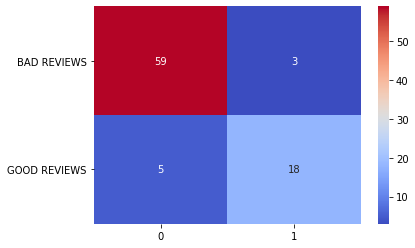

In [44]:
pl = sns.heatmap(confusion_matrix(y_test,predictions),annot=True,cmap='coolwarm')
pl.set_yticklabels(labels = ['BAD REVIEWS','GOOD REVIEWS'],rotation=0)
print('\n')
print(classification_report(y_test,predictions))

In [45]:
pre = []
result_df = pd.DataFrame()
result_df['Sentiment'] = y_test.apply(lambda x : 'Good' if x == 1 else 'Bad' )